# Assignment 4: Performance comparison between 4 optimizers
1. Custome Optimizer
2. SGD
3. RMSProp
4. Adam

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import SGD, RMSprop, Adam
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 28 * 28).astype('float32') / 255
X_test = X_test.reshape(-1, 28 * 28).astype('float32') / 255
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
# Custom optimizer class
class CustomeOptimizer:
    def __init__(self, model, lr=0.001, beta1=0.9, beta2=0.999, beta3=0.999, epsilon=1e-7):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta3 = beta3
        self.epsilon = epsilon
        self.model = model
        self.t = 0
        self.ms = [np.zeros_like(weight) for weight in model.trainable_weights]
        self.vs = [np.zeros_like(weight) for weight in model.trainable_weights]
        self.us = [np.zeros_like(weight) for weight in model.trainable_weights]

    def apply_gradients(self, grads):
        self.t += 1
        beta1_t = self.beta1 ** self.t
        beta2_t = self.beta2 ** self.t
        beta3_t = self.beta3 ** self.t

        for i, grad in enumerate(grads):
            self.ms[i] = self.beta1 * self.ms[i] + (1 - self.beta1) * grad
            self.vs[i] = self.beta2 * self.vs[i] + (1 - self.beta2) * (grad ** 2)
            self.us[i] = self.beta3 * self.us[i] + (1 - self.beta3) * (grad ** 3)

            m_hat = self.ms[i] / (1 - beta1_t)
            v_hat = self.vs[i] / (1 - beta2_t)
            u_hat = self.us[i] / (1 - beta3_t)


            v_hat_rt = np.sqrt(v_hat) + self.epsilon
            u_hat_rt = np.cbrt(u_hat) + self.epsilon

            d = np.maximum(v_hat_rt + u_hat_rt * self.epsilon, self.epsilon)

            self.model.trainable_weights[i].assign_sub(self.lr * m_hat / d)

    def zero_grad(self):
        self.ms = [np.zeros_like(m) for m in self.ms]
        self.vs = [np.zeros_like(v) for v in self.vs]
        self.us = [np.zeros_like(u) for u in self.us]

In [ ]:
def build_model(with_dropout):
    model = Sequential([
        Flatten(input_shape=(784,)),
        Dense(256, activation='relu'),
        Dropout(0.2) if with_dropout else tf.keras.layers.Lambda(lambda x: x),
        Dense(64, activation='relu'),
        Dropout(0.2) if with_dropout else tf.keras.layers.Lambda(lambda x: x),
        Dense(10, activation='softmax')
    ])
    return model

In [ ]:
def train_evaluate(model, optimizer_name, X_train, y_train, X_test, y_test, epochs=10, with_dropout=False):
    start_time = time.time()
    history = None

    if optimizer_name == "SGD":
        optimizer = SGD()
    elif optimizer_name == "RMSprop":
        optimizer = RMSprop()
    elif optimizer_name == "Adam":
        optimizer = Adam()
    else:
        optimizer = CustomeOptimizer(model)

    if optimizer_name != "CustomeOptimizer":
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=128, verbose=0, validation_data=(X_test, y_test))
    else:
        optimizer = CustomeOptimizer(model)
        for epoch in range(epochs):
            optimizer.zero_grad()
            with tf.GradientTape() as tape:
                predictions = model(X_train, training=True)
                loss = tf.keras.losses.categorical_crossentropy(y_train, predictions)
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(grads)

        model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=128, verbose=0, validation_data=(X_test, y_test))

    duration = time.time() - start_time
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    train_loss, train_accuracy = history.history['loss'][-1], history.history['accuracy'][-1]
    return model, train_accuracy, test_accuracy, train_loss, test_loss, duration

In [ ]:
def predict_and_compare(model, X_test, y_test):
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    correct_indices = np.nonzero(predicted_classes == true_classes)[0]
    incorrect_indices = np.nonzero(predicted_classes != true_classes)[0]

    print(f"Correctly predicted: {len(correct_indices)}")
    print(f"Incorrectly predicted: {len(incorrect_indices)}")

    plt.figure(figsize=(10, 4))
    for i, correct in enumerate(correct_indices[:2]):
        plt.subplot(2,4,i+1)
        plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
        plt.title(f"Predicted {predicted_classes[correct]}, True {true_classes[correct]}")

    for i, incorrect in enumerate(incorrect_indices[:2]):
        plt.subplot(2,4,i+5)
        plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
        plt.title(f"Predicted {predicted_classes[incorrect]}, True {true_classes[incorrect]}")

    plt.tight_layout()
    plt.show()

In [ ]:
# Main code
optimizers = ['SGD', 'RMSprop', 'Adam', 'CustomeOptimizer']
results = {}
for optimizer_name in optimizers:
    for with_dropout in [False, True]:
        key = f"{optimizer_name}{' + Dropout' if with_dropout else ''}"
        model = build_model(with_dropout=with_dropout)
        model, train_accuracy, test_accuracy, train_loss, test_loss, duration = train_evaluate(model, optimizer_name, X_train, y_train, X_test, y_test, with_dropout=with_dropout)
        results[key] = {"Model": model, "Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy, "Train Loss": train_loss, "Test Loss": test_loss, "Duration": duration}

Configuration: SGD
313/313 [==============================] - 1s 3ms/step
Correctly predicted: 9383
Incorrectly predicted: 617


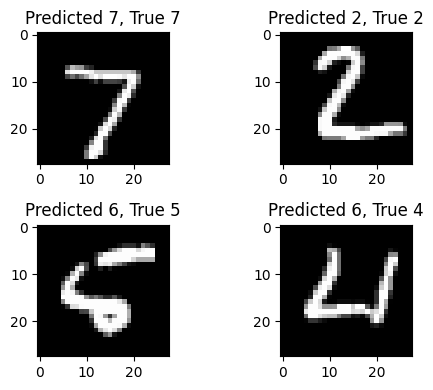

  Training Accuracy: 0.9365333318710327
  Training Loss: 0.22409239411354065
  Test Accuracy: 0.9383000135421753
  Test Loss: 0.21382515132427216
  Duration: 43.5620813369751 seconds

Configuration: SGD + Dropout
313/313 [==============================] - 1s 3ms/step
Correctly predicted: 9389
Incorrectly predicted: 611


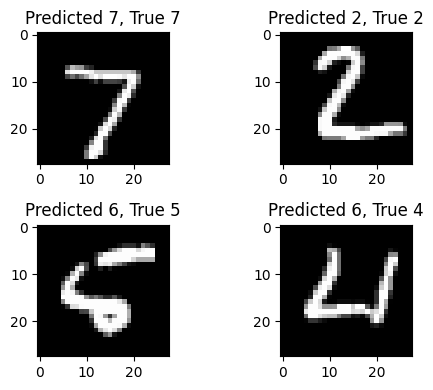

  Training Accuracy: 0.9108166694641113
  Training Loss: 0.3012905716896057
  Test Accuracy: 0.9388999938964844
  Test Loss: 0.21370825171470642
  Duration: 41.90550875663757 seconds

Configuration: RMSprop
313/313 [==============================] - 1s 3ms/step
Correctly predicted: 9798
Incorrectly predicted: 202


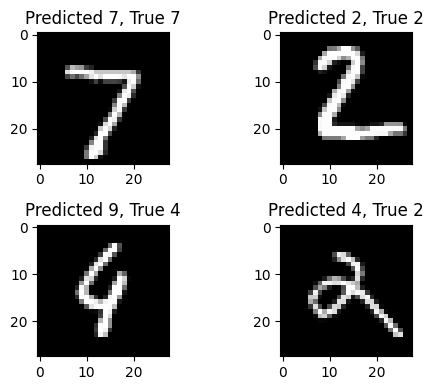

  Training Accuracy: 0.9959499835968018
  Training Loss: 0.012892471626400948
  Test Accuracy: 0.9797999858856201
  Test Loss: 0.08349283784627914
  Duration: 46.2911319732666 seconds

Configuration: RMSprop + Dropout
313/313 [==============================] - 1s 2ms/step
Correctly predicted: 9806
Incorrectly predicted: 194


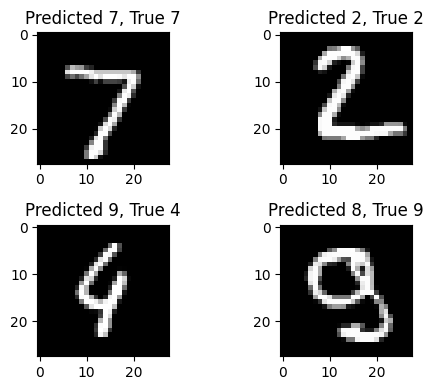

  Training Accuracy: 0.9851666688919067
  Training Loss: 0.04882963374257088
  Test Accuracy: 0.9805999994277954
  Test Loss: 0.07766738533973694
  Duration: 44.09517002105713 seconds

Configuration: Adam
313/313 [==============================] - 1s 3ms/step
Correctly predicted: 9792
Incorrectly predicted: 208


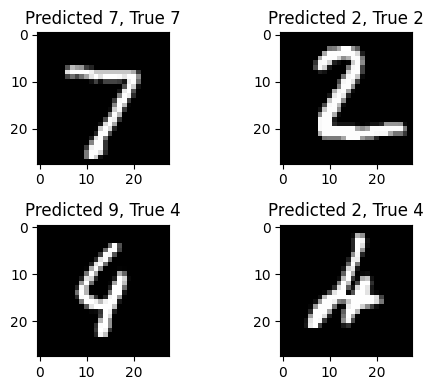

  Training Accuracy: 0.9957166910171509
  Training Loss: 0.013662793673574924
  Test Accuracy: 0.979200005531311
  Test Loss: 0.08254965394735336
  Duration: 31.10409688949585 seconds

Configuration: Adam + Dropout
313/313 [==============================] - 1s 3ms/step
Correctly predicted: 9801
Incorrectly predicted: 199


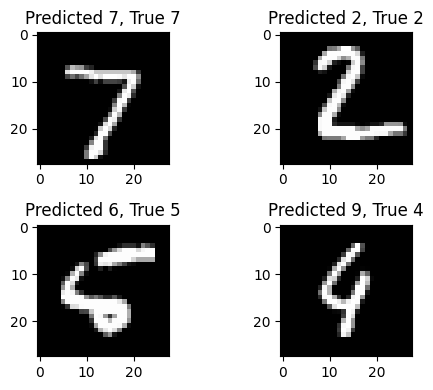

  Training Accuracy: 0.9863333106040955
  Training Loss: 0.0416022427380085
  Test Accuracy: 0.9800999760627747
  Test Loss: 0.07230404764413834
  Duration: 35.362854957580566 seconds

Configuration: CustomeOptimizer
313/313 [==============================] - 1s 3ms/step
Correctly predicted: 9816
Incorrectly predicted: 184


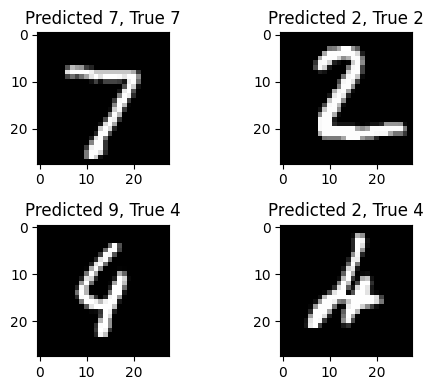

  Training Accuracy: 0.9960333108901978
  Training Loss: 0.01233930978924036
  Test Accuracy: 0.9815999865531921
  Test Loss: 0.0741875022649765
  Duration: 57.009647846221924 seconds

Configuration: CustomeOptimizer + Dropout
313/313 [==============================] - 1s 4ms/step
Correctly predicted: 9815
Incorrectly predicted: 185


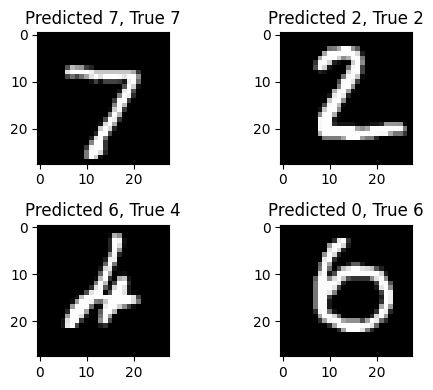

  Training Accuracy: 0.9854333400726318
  Training Loss: 0.046193718910217285
  Test Accuracy: 0.9815000295639038
  Test Loss: 0.07390831410884857
  Duration: 58.55591940879822 seconds



In [ ]:
for key, value in results.items():
    print(f"Configuration: {key}")
    model = value["Model"]
    predict_and_compare(model, X_test, y_test)
    print(f"  Training Accuracy: {value['Train Accuracy']}")
    print(f"  Training Loss: {value['Train Loss']}")
    print(f"  Test Accuracy: {value['Test Accuracy']}")
    print(f"  Test Loss: {value['Test Loss']}")
    print(f"  Duration: {value['Duration']} seconds\n")

<ipython-input-31-d90d8a0b8e29>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(configs, rotation=45, ha="right")
<ipython-input-31-d90d8a0b8e29>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(configs, rotation=45, ha="right")
<ipython-input-31-d90d8a0b8e29>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(configs, rotation=45, ha="right")


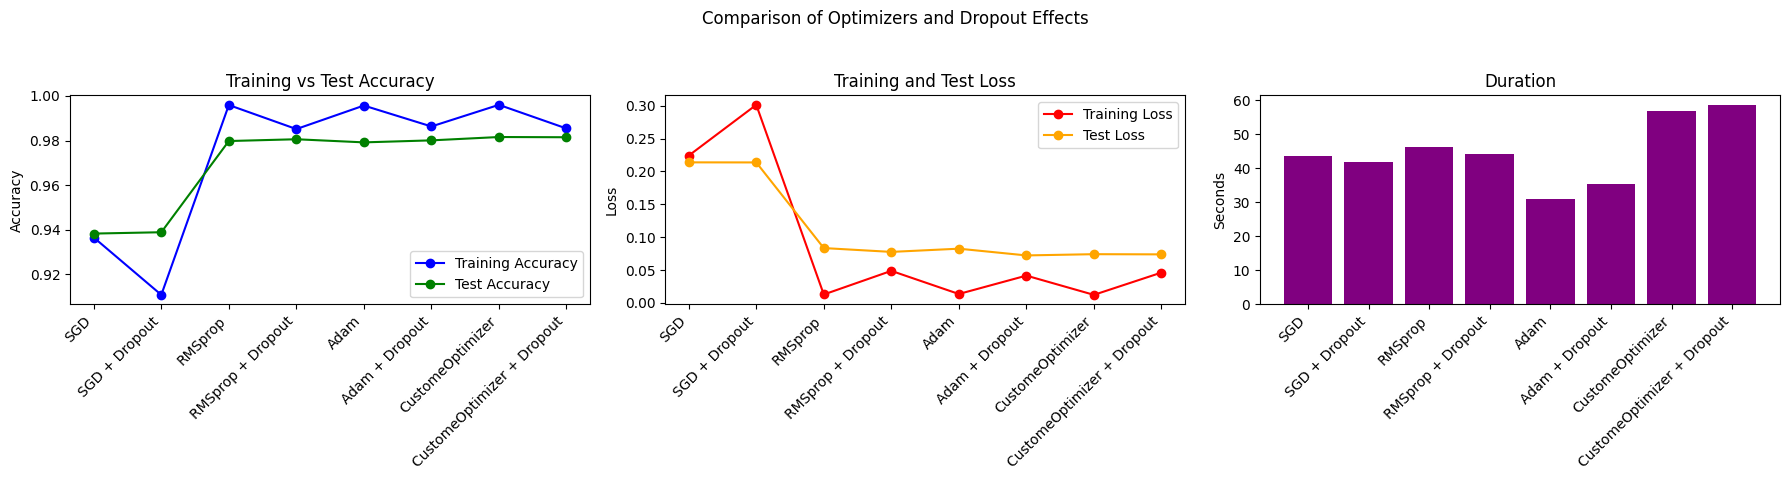

In [ ]:
configs = list(results.keys())
train_accuracies = [results[config]['Train Accuracy'] for config in configs]
test_accuracies = [results[config]['Test Accuracy'] for config in configs]
train_losses = [results[config]['Train Loss'] for config in configs]
test_losses = [results[config]['Test Loss'] for config in configs]
durations = [results[config]['Duration'] for config in configs]

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Comparison of Optimizers and Dropout Effects')

# Training vs Test Accuracy
ax[0].plot(configs, train_accuracies, marker='o', linestyle='-', color='blue', label='Training Accuracy')
ax[0].plot(configs, test_accuracies, marker='o', linestyle='-', color='green', label='Test Accuracy')
ax[0].set_title('Training vs Test Accuracy')
ax[0].set_xticklabels(configs, rotation=45, ha="right")
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Training vs Test Loss
ax[1].plot(configs, train_losses, marker='o', linestyle='-', color='red', label='Training Loss')
ax[1].plot(configs, test_losses, marker='o', linestyle='-', color='orange', label='Test Loss')
ax[1].set_title('Training and Test Loss')
ax[1].set_xticklabels(configs, rotation=45, ha="right")
ax[1].set_ylabel('Loss')
ax[1].legend()

# Duration
ax[2].bar(configs, durations, color='purple')
ax[2].set_title('Duration')
ax[2].set_xticklabels(configs, rotation=45, ha="right")
ax[2].set_ylabel('Seconds')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Results
### Speed
Adam demonstrated the shortest training duration across both configurations (without dropout: 31.1 seconds, with dropout: 35.4 seconds), indicating its efficiency in convergence. The custome optimizer was the slowest (without dropout: 57.0 seconds, with dropout: 58.6 seconds), likely due to the additional computations required for the third moment of the gradients.

### Stability and Robustness
All optimizers showed high stability and robustness, with final testing accuracies above 93%. The custome optimizer achieved the highest testing accuracy (without dropout: 98.16%, with dropout: 98.15%), suggesting its effectiveness in navigating the optimization. RMSprop and Adam also performed well, with slight improvements in testing accuracy when dropout was applied, indicating their robustness to overfitting.

### Accuracy and Loss
The custome optimizer not only achieved the highest testing accuracy but also maintained a low testing loss, illustrating its ability to generalize well on unseen data. RMSprop and Adam showed significant improvements over SGD, especially in terms of training loss, which was notably lower for RMSprop and Adam, indicating more effective learning during training.